# Super Resolution

In [1]:
"""
44x44 to 176x176
Super Resolution
"""
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Input, Activation
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from skimage.transform import pyramid_expand
from Subpixel import Subpixel
from DataGenerator import DataGenerator

# Memory Allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


ORG_PATH = os.getcwd()
BASE_PATH = "D:\\00_MLDL\\00_BreadBrother\\02_Super_Resolution\\processed_img"

x_train_list = sorted(glob.glob(os.path.join(BASE_PATH, "x_train", "*.npy")))
x_val_list = sorted(glob.glob(os.path.join(BASE_PATH, "x_val", "*.npy")))

print(len(x_train_list))
print(x_train_list[0])
print(x_val_list[0])

Using TensorFlow backend.
1 Physical GPUs, 1 Logical GPUs
162770
D:\00_MLDL\00_BreadBrother\02_Super_Resolution\processed_img\x_train\000001.npy
D:\00_MLDL\00_BreadBrother\02_Super_Resolution\processed_img\x_val\162771.npy


(44, 44, 3) (44, 44, 3)
Wall time: 18 ms


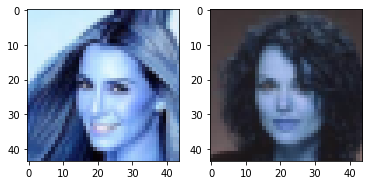

In [2]:
%%time
x1 = np.load(x_train_list[0])
x2 = np.load(x_val_list[0])

print(x1.shape, x2.shape)

plt.subplot(1,2,1)
plt.imshow(x1)
plt.subplot(1,2,2)
plt.imshow(x2)

In [3]:
train_gen = DataGenerator(list_IDs=x_train_list, labels=None, batch_size=16, dim=(44, 44), n_channels=3, n_classes=None, shuffle=True)
#print(list("aaabbb".split()))
#te = list((train_gen.list_IDs[0].split(os.sep)[0]+os.sep).split()) + train_gen.list_IDs[0].split(os.sep)[1:]
#a = train_gen.list_IDs[0].split(os.sep)
#print(os.path.join(os.sep, *te))
#print(os.path.join(os.sep, *a))

val_gen = DataGenerator(list_IDs=x_val_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=False)



In [4]:
%%time
upscale_factor = 4

inputs = Input(shape=(44, 44, 3))

net = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
net = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=upscale_factor**2, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Subpixel(filters=3, kernel_size=3, r=upscale_factor, padding='same')(net)
outputs = Activation('relu')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44, 44, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 16)        4624      
_________________________________________________________________
subpixel_1 (Subpixel)        (None, 176, 176, 3)       6960      
_________________________________________________________________
activation_1 (Activation)    (None, 176, 176, 3)       0   

# Training

In [5]:
%%time
history = model.fit_generator(train_gen, validation_data=val_gen, epochs=5, verbose=1, callbacks=[ModelCheckpoint(os.path.abspath(".\\models\\model.h5"), monitor='val_loss', verbose=1, save_best_only=True)])
#history = model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1, callbacks=[ModelCheckpoint('models\\model.h5', monitor='val_loss', verbose=1, save_best_only=True)])



Epoch 1/5
10173/10173 [==============================] - 9496s 933ms/step - loss: 0.0024 - val_loss: 0.0023

Epoch 00001: val_loss improved from inf to 0.00230, saving model to d:\GitHub\super_resolution_clone\models\model.h5
Epoch 2/5
10173/10173 [==============================] - 27669s 3s/step - loss: 0.0015 - val_loss: 0.0022

Epoch 00002: val_loss improved from 0.00230 to 0.00221, saving model to d:\GitHub\super_resolution_clone\models\model.h5
Epoch 3/5
10173/10173 [==============================] - 8421s 828ms/step - loss: 0.0014 - val_loss: 0.0021

Epoch 00003: val_loss improved from 0.00221 to 0.00214, saving model to d:\GitHub\super_resolution_clone\models\model.h5
Epoch 4/5
10173/10173 [==============================] - 8118s 798ms/step - loss: 0.0014 - val_loss: 0.0021

Epoch 00004: val_loss did not improve from 0.00214
Epoch 5/5
10173/10173 [==============================] - 33066s 3s/step - loss: 0.0013 - val_loss: 0.0021

Epoch 00005: val_loss improved from 0.00214 to 0.

# Prediction

In [6]:
x_test_list = sorted(glob.glob(os.path.join(BASE_PATH, "x_test", "*.npy")))
y_test_list = sorted(glob.glob(os.path.join(BASE_PATH, "y_test", "*.npy")))

print(len(x_test_list), len(y_test_list))
print(x_test_list[0])

19962 19962
D:\00_MLDL\00_BreadBrother\02_Super_Resolution\processed_img\x_test\182638.npy


(44, 44, 3) (176, 176, 3)


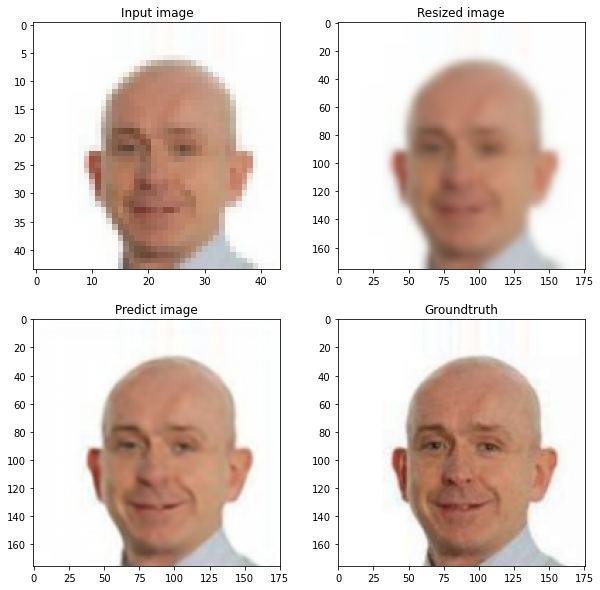

In [35]:
test_idx = 1000

#model = load_model(os.path.join(ORG_PATH, "models\\model.h5"))

x1_test = np.load(x_test_list[test_idx])
x1_test_resized = pyramid_expand(x1_test, upscale=4, multichannel=True) # multichannel param setting
y1_test = np.load(y_test_list[test_idx])
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

print(x1_test.shape, y1_test.shape)

x1_test = (x1_test * 255).astype(np.uint8)
x1_test_resized = (x1_test_resized * 255).astype(np.uint8)
y1_test = (y1_test * 255).astype(np.uint8)
y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)

x1_test = cv2.cvtColor(x1_test, cv2.COLOR_BGR2RGB)
x1_test_resized = cv2.cvtColor(x1_test_resized, cv2.COLOR_BGR2RGB)
y1_test = cv2.cvtColor(y1_test, cv2.COLOR_BGR2RGB)
y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize = (10, 10))

plt.subplot(2,2,1)
plt.title("Input image")
plt.imshow(x1_test)

plt.subplot(2,2,2)
plt.title("Resized image")
plt.imshow(x1_test_resized)

plt.subplot(2,2,3)
plt.title("Predict image")
plt.imshow(y_pred)

plt.subplot(2,2,4)
plt.title("Groundtruth")
plt.imshow(y1_test)

#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=0.2, wspace=0.2)
fig.savefig(f"result_img/result{test_idx}.png") 